# Инициализация

In [60]:
import os
import torch
from torchvision import datasets, transforms
from torch.utils.data.dataset import Dataset
from tqdm.notebook import tqdm
from time import time
import random
from shutil import copyfile
import numpy as np
import cv2  
from torch.autograd import Variable


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!git clone https://github.com/opencv/opencv.git >&-
pip install face-recognition

In [ ]:
import face_recognition

In [66]:
mkdir Video

mkdir: cannot create directory ‘Video’: File exists


# Вспомогательные классы и функции

Класс кастомного датасета с сохранением пути до изображения

In [14]:
class ImageFolderWithPaths(datasets.ImageFolder):
    """Кастомный датасет, включающий путь до изображений. Расширяет
 torchvision.datasets.ImageFolder
    """
    # Переопределяет метод __getitem__. Этот метод вызывает dataloader
    def __getitem__(self, index):
        # Это то, что обычно возвращает ImageFolder
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        # Путь до изображения
        path_to_img = self.imgs[index][0]
        # make a new tuple that includes original and the path
        tuple_with_path = (original_tuple + (path_to_img,))
        return tuple_with_path

Фукция создания загрузчика данных

In [15]:
def load_images_for_vgg16(root, bath_size):
    # Изображения необходимо преоброзовать в такой формат, на котором обучалась VGG16
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    
    data = ImageFolderWithPaths(root=root, transform=transform)
    data_loader = torch.utils.data.DataLoader(data,batch_size=bath_size, num_workers=os.cpu_count())
    return data_loader

Функция формирования признаков изображений (прогон изображений через VGG16)

In [57]:
def create_image_features(data,train=True, face=False):
  """ Изображения прогоняются через предварительно обученную сеть VGG16 для
   создания набора признаков в виде 4096-ти мерного вектора """

  features = []
  if face:
    for img in data:
      img = img.to(device=device)
      predicted = vgg16(img)
      predicted_np = predicted.cpu().detach().numpy()[0]
      features.append(predicted_np)
    return features
  else:
    for batch_idx, (img, label, path) in enumerate(data):
      img = img.to(device=device)
      label = label.to(device=device)
      predicted = vgg16(img)
      predicted_np = predicted.cpu().detach().numpy()[0]
      if train:
        features.append((predicted_np, label.item()))
      else:
        img_name = path[0].split('/')[-1]
        features.append((predicted_np, label.item(), img_name))   
    return features

#Загрузка и предобработка файлов

In [ ]:
mkdir train; mkdir test;

In [ ]:
cd "/content/drive/My Drive/ml/photo/" 

/content/drive/My Drive/ml/photo


Распаковка архива с набором данных для обучения

In [ ]:
!sudo tar -xvf train_data.gz --directory /content/train --strip-components 1 >&-


Очистка не ревалентных изображений (начинаются с ".")

In [ ]:
folder_data = ['real/', 'spoof/']
path = "/content/train/"
for folder in folder_data:
  for file in os.listdir(path+folder):
    if file[0] == ".":
      os.remove(path+folder+file)

Балансировка данных

In [ ]:
path = "/content/train/"
count_real = round(len(os.listdir(path+"real")))
image_spoof = os.listdir(path+"spoof")
random.shuffle(image_spoof)
count_spoof = round(len(image_spoof))
print(f"Реальных изображений: {count_real}, Поддельных: {count_spoof}")
for file in image_spoof[:count_spoof-count_real]:
    os.remove(path+"spoof/"+file)

Реальных изображений: 1223, Поддельных: 7076


Распаковка архива с набором данных для тестирования

In [ ]:
!sudo tar -xvf test.tar.gz --directory /content/test >&-


Очистка не ревалентных изображений (начинаются с ".")

In [ ]:
for file in os.listdir("/content/test/"):
  if file[0] == ".":
    os.remove("/content/final_test/"+file)

# Формирование признаков с помощью VGG16

In [ ]:
pip install optunity

     |████████████████████████████████| 4.6MB 26.4MB/s 
  Created wheel for optunity: filename=Optunity-1.1.1-cp36-none-any.whl size=72024 sha256=183f3d1057b951bbd717047342d8a628312e400ee9ac4d7a5026eac3e16a2fbc
  Stored in directory: /root/.cache/pip/wheels/c9/e2/80/d3794524ae0042e147e035e132ec5fac09b8794b4acd94f046
Successfully built optunity


In [ ]:
import torchvision.models as models
import torch.nn as nn
import torch
from sklearn import svm
from sklearn.metrics import confusion_matrix
import optunity
import optunity.metrics
import numpy as np
import sklearn
import pandas as pd

In [ ]:
vgg16 = models.vgg16(pretrained=True)

if torch.cuda.is_available():
    vgg16.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


"Лоботомия" VGG16 - удаляем три последних слоя:

Линейный, функцию активации релу и дропаут

In [ ]:
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-6])
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
)

Создаем наборы данных, формируем признаки

In [ ]:
root = "/content/train/"
# Создание тренировочного и тестового набора данных
train_and_test_data = load_images_for_vgg16(root=root, bath_size=1)
# Создание признаков изображений и меток
features_and_labels = create_image_features(train_and_test_data, train=True)
random.shuffle(features_and_labels)
# Распаковка списка кортежей
features = np.zeros(len(features_and_labels))
labels = np.zeros(len(features_and_labels))
features, labels = zip(*features_and_labels)
features = list(features)
labels = list(labels)

# Поиск параметров и тестирование модели SVC

Проверка точности модели при стандартных параметрах c линейным ядром

In [ ]:
@optunity.cross_validated(x=features, y=labels, num_folds=5)
def svm_default_auroc(x_train, y_train, x_test, y_test):
    model = svm.SVC(kernel="linear").fit(x_train, y_train)
    decision_values = model.decision_function(x_test)
    auc = optunity.metrics.roc_auc(y_test, decision_values)
    return auc

svm_default_auroc()

0.8271417179239119

Диапозон параметров для поиска наилучших параметров

In [ ]:
space = {'kernel':  {'rbf': {'logGamma': [-5, 0], 'C': [0, 10]},
                    'poly': {'degree': [2, 5], 'C': [0, 5], 'coef0': [0, 2]}
                    }
         }

In [ ]:
def train_model(x_train, y_train, kernel, C, logGamma, degree, coef0):
    """Универсальная обучающая функция с аргументами, основанными на выбранном ядре."""
    if kernel == 'linear':
        model = svm.SVC(kernel=kernel, C=C)
    elif kernel == 'poly':
        model = svm.SVC(kernel=kernel, C=C, degree=degree, coef0=coef0)
    elif kernel == 'rbf':
        model = svm.SVC(kernel=kernel, C=C, gamma=10 ** logGamma)
    else:
        raise ArgumentError("Unknown kernel function: %s" % kernel)
    model.fit(x_train, y_train)
    return model

In [ ]:
@optunity.cross_validated(x=features, y=labels, num_folds=5)
def svm_tuned_auroc(x_train, y_train, x_test, y_test, kernel='linear', C=0, logGamma=0, degree=0, coef0=0):
    model = train_model(x_train, y_train, kernel, C, logGamma, degree, coef0)
    decision_values = model.decision_function(x_test)
    return optunity.metrics.roc_auc(y_test, decision_values)

 Тестирования моделей с ризличными параметрами

In [ ]:
optimal_svm_pars, info, _ = optunity.maximize_structured(svm_tuned_auroc, space, num_evals=10, pmap=optunity.pmap)
print("Optimal parameters" + str(optimal_svm_pars))
print("AUROC of tuned SVM: %1.3f" % info.optimum)

Optimal parameters{'kernel': 'rbf', 'C': 4.6337890625, 'coef0': None, 'degree': None, 'logGamma': -3.85009765625}
AUROC of tuned SVM: 0.993


Результат тестирования

In [ ]:
df = optunity.call_log2dataframe(info.call_log)
df

C  logGamma kernel     coef0    degree     value
0  5.883789 -0.725098    rbf       NaN       NaN  0.541206
1  4.890137       NaN   poly  1.286133  3.003418  0.988159
2  1.765137       NaN   poly  0.536133  4.128418  0.987989
3  2.133789 -0.100098    rbf       NaN       NaN  0.500822
4  4.633789 -3.850098    rbf       NaN       NaN  0.993192
5  3.015137       NaN   poly  0.036133  3.378418  0.986961
6  2.077637       NaN   poly  1.411133  2.440918  0.986864
7  2.758789 -4.162598    rbf       NaN       NaN  0.989922
8  0.258789 -0.412598    rbf       NaN       NaN  0.504452
9  3.327637       NaN   poly  1.911133  4.690918  0.987455

Тест модели с наилучшими параметрами

In [ ]:
@optunity.cross_validated(x=features, y=labels, num_folds=5)
def svm_default_auroc(x_train, y_train, x_test, y_test):
    model = svm.SVC(kernel="rbf", C=3.71, gamma=10**-3.961).fit(x_train, y_train)
    decision_values = model.decision_function(x_test)
    auc = optunity.metrics.roc_auc(y_test, decision_values)
    return auc

svm_default_auroc()


0.990623711971122

# Обучение модели и финальный тест

Обучение модели

In [ ]:
model = svm.SVC(probability=True, kernel="rbf", C=4.633789, gamma=10**-3.850098).fit(features, labels)


Финальный тест

In [ ]:
root = "/content/test/"
# Создание тренировочного и тестового набора данных
final_test_data = load_images_for_vgg16(root=root, bath_size=1)
# Создание признаков изображений и меток
features_and_labels = create_image_features(final_test_data, train=False)
# Распаковка списка кортежей
features_test = np.zeros(len(features_and_labels))
labels_test = np.zeros(len(features_and_labels))
img_name = np.zeros(len(features_and_labels))
features_test, labels_test, img_name = zip(*features_and_labels)
features_test = list(features_test)
labels_test = list(labels_test)
img_name = list(img_name)

Предсказание модели

In [ ]:
np.set_printoptions(suppress=True)
predict = model.predict_proba(features_test)


Вероятность предсказания реальных изображений

In [ ]:
probality = [p[0] for p in predict]

Создание датафрейма

In [ ]:
data = [img_name, probality]
df = pd.DataFrame.from_records(data, index=['Имя файла', 'Вероятность класса real']).T
df = df.sort_values(by=["Имя файла"])
df.head(20)

Имя файла Вероятность класса real
0   0004TGCC.png             3.01633e-14
1   00BMIGHK.png             1.68572e-05
2   00DH97CQ.png              0.00614774
3   00GZOF2Z.png                0.925393
4   00I3IO2B.png              0.00358108
5   00J6CTJ6.png                0.825335
6   00S0VB8K.png                 0.64147
7   00Y667ZT.png             8.57681e-06
8   01HMQTOX.png                0.193194
9   01RRI4YP.png                0.968932
10  026WCAFZ.png                0.104207
11  027LH1AW.png                0.342981
12  02KGFMBE.png                0.182308
13  02N9OSO4.png                0.171138
14  02QWSY42.png                0.919021
15  0338EIMA.png               0.0600158
16  039UOUG3.png                0.973165
17  03JU8VX8.png                0.288417
18  03KA7ID9.png               0.0252618
19  046GQHF0.png             4.66361e-10

Сохранение датафрейма в пдф

In [ ]:
df.to_csv("probability_of_real_images_Pivkin2.csv", index=False)

# Сохранение модели SVC

In [ ]:
import joblib
filename = 'anti_spoof_face.joblib.pkl'
_ = joblib.dump(model, filename, compress=9)

# Загрузка модели SVC и VGG16

In [17]:
from google.colab import drive
import joblib
import torchvision.models as models
import torch.nn as nn
import torch
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
path_to_model = '/content/drive/My Drive/ml/photo/anti_spoof_face.joblib.pkl'
model = joblib.load(path_to_model)

In [19]:
vgg16 = models.vgg16(pretrained=True)

if torch.cuda.is_available():
    vgg16.cuda()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
vgg16.classifier = nn.Sequential(*list(vgg16.classifier.children())[:-6])
vgg16.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
)

# Тест пользовательских изображений

In [ ]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
import os

In [ ]:
def show_image(path, title):
  img = cv2.imread(path)
  img_cvt = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  plt.imshow(img_cvt)
  plt.title(title)
  plt.show()

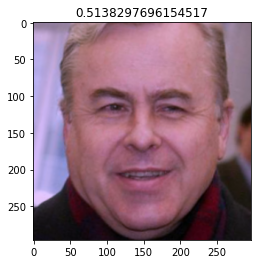

CPU times: user 168 ms, sys: 64.8 ms, total: 233 ms
Wall time: 307 ms


In [ ]:
%%time
root = "/content/images/"
file_name = os.listdir(root+"test/")
for f in file_name:
  if f[0] == ".":
    file_name.remove(f)
path = root + "test/" + file_name[0]
path = os.path.normpath(path)
data = load_images_for_vgg16(root, 1)
# Создание признаков изображений и меток
features_and_labels = create_image_features(data, train=False)
# Распаковка списка кортежей
features = features_and_labels[0][0]
labels = features_and_labels[0][1]
np.set_printoptions(suppress=True)
# Предскзаание модели
predict = model.predict_proba(features.reshape(1, 4096))
show_image(path, predict[0][0])

# Тест модели на видео

## Захват видео

In [73]:
!pip install ffmpeg-python


from IPython.display import HTML, Javascript, display
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg

video_file_test = '/content/Video/osy_test.mp4' 
  

VIDEO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var my_btn_txt = document.createTextNode("Press to start recording");
my_btn.appendChild(my_btn_txt);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);
var base64data = 0;
var reader;
var recorder, videoStream;
var recordButton = my_btn;
var handleSuccess = function(stream) {
 videoStream = stream;
 var options = { 
 mimeType : 'video/webm;codecs=vp9' 
  };            
 recorder = new MediaRecorder(stream, options);
 recorder.ondataavailable = function(e) { 
 var url = URL.createObjectURL(e.data);
 var preview = document.createElement('video');
 preview.controls = true;
 preview.src = url;
 document.body.appendChild(preview);
 reader = new FileReader();
 reader.readAsDataURL(e.data); 
 reader.onloadend = function() {
 base64data = reader.result;
    }
  };
  recorder.start();
  };
recordButton.innerText = "Recording... press to stop";
navigator.mediaDevices.getUserMedia({video: true}).then(handleSuccess);
function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      videoStream.getVideoTracks()[0].stop();
      recordButton.innerText = "Saving the recording... Please wait!"
  }
}
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}
var data = new Promise(resolve=>{
recordButton.onclick = ()=>{
toggleRecording()
sleep(2000).then(() => {
  // wait 2000ms for the data to be available
  resolve(base64data.toString())
});
}
});
      
</script>
"""

def start_webcam():
  js = Javascript('''
    async function startWebcam() {
      const div = document.createElement('div');
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      
      return;
    }
    ''')
  
  display(js)
  data = eval_js('startWebcam()')

## Создание видео

In [ ]:
start_webcam()

def get_video():
  display(HTML(VIDEO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  
  return binary

In [ ]:
videofile = get_video()
with open(video_file_test, 'wb') as f:
 f.write(videofile)

## Распознование лица на видео, тест

In [77]:
def prepocessing_image(img):
  to_pil = transforms.ToPILImage()
  resize = transforms.Resize(224)
  normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
  to_tensor = transforms.ToTensor()
  t_img = Variable(normalize(to_tensor(resize(to_pil(img)))).unsqueeze(0))
  return t_img

In [78]:
def load_face_for_vgg16(img, bath_size):
    data_loader = torch.utils.data.DataLoader(img,batch_size=bath_size, num_workers=os.cpu_count())
    return data_loader

In [81]:
FRAME_THICKNESS = 3
FONT_THICKNESS = 2
margin = 30;  

video_file = "/content/Video/osy_test.mp4"

face_cascade = cv2.CascadeClassifier('/content/opencv/data/haarcascades/haarcascade_frontalface_default.xml') 

fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out_video_name = "output.mp4"
out = cv2.VideoWriter('/content/Video/'+out_video_name,fourcc, 20.0, (640,480))

cap = cv2.VideoCapture(video_file) 
while cap.isOpened():
 
  ret, img = cap.read() 
  if not ret:
    break

  faces = face_cascade.detectMultiScale(img, 1.3, 5) 
 
  for (x,y,w,h) in faces: 
      cv2.rectangle(img, (x,y), (x+w,y+h),(255,255,0),FRAME_THICKNESS)
      crop_img = img[y-margin:y+h+margin, x-margin:x+w+margin].copy()
  try:
    t_img = prepocessing_image(crop_img)
    data = load_face_for_vgg16(t_img, 1)
    features = create_image_features(data, train=False, face=True)[0]
    np.set_printoptions(suppress=True)
    predict = model.predict_proba(features.reshape(1, 4096))[0]
    if predict.argmax() == 0:
      text = f"Real: {predict[0]}"
    elif predict.argmax() == 1:
      text = f"Spoof: {predict[1]}"
    for (x,y,w,h) in faces: 
      cv2.putText(img, text, (h+10, w+10), cv2.FONT_HERSHEY_SIMPLEX,
                              0.5, (200, 200, 200), FONT_THICKNESS)
  except:
    pass
  out.write(img)
  if cv2.waitKey(1) & 0xFF == ord('q'):
    break

out.release()
cap.release() 

For example, here we download and display a PNG image of the Colab logo: